In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

In [15]:
def run_model(dataset, perfect):
    df = pd.read_csv(dataset)
    df2 = pd.read_csv(perfect)

    training = df2.iloc[100:] #select the last 1000 rows
    test = df.iloc[:100] #select all but the last 1000 rows

    
    #normalize the data between 0 and 1
    for e in range(3, len(training.columns)): #iterate for each column
        num = max(training.iloc[:, e].max(), test.iloc[:, e].max()) #check the maximum value in each column
        if num < 10:
            training.iloc[:, e] /= 10
            test.iloc[:, e] /= 10
        elif num < 100:
            training.iloc[:, e] /= 100
            test.iloc[:, e] /= 100
        elif num < 1000:
            training.iloc[:, e] /= 1000
            test.iloc[:, e] /= 1000
        elif num < 10000:
            training.iloc[:, e] /= 10000
            test.iloc[:, e] /= 10000
        else:
            print("Error in normalization! Please check!")
            
   # training = training.sample(frac=1) #shuffle the training data
    #test = test.sample(frac=1) #shuffle the test data
    
    home = [1,0,0]
    draw = [0,1,0]
    away = [0,0,1]
    
    for x in range(3):
        #all rows, all columns except for the last 3 columns
        training_input  = training.iloc[:, 3:]
        #all rows, the last 3 columns
        training_output = training.iloc[:, :3]
        #all rows, all columns except for the last 3 columns
        test_input  = test.iloc[:, 3:]
        #all rows, the last 3 columns
        test_output = test.iloc[:, :3]
        
        training_output = convert_output_win(training_output, home[x], draw[x], away[x])
        test_output = convert_output_win(test_output,home[x], draw[x], away[x])
        
        training_input = torch.FloatTensor(training_input.values)
        training_output = torch.FloatTensor(training_output.values)
        test_input = torch.FloatTensor(test_input.values)
        test_output = torch.FloatTensor(test_output.values)
        
        input_size = training_input.size()[1] # number of features selected
        hidden_size = 15 # number of nodes/neurons in the hidden layer
        model = Net(input_size, hidden_size) # create the model
        criterion = torch.nn.BCELoss() # works for binary classification

        #with momentum parameter
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.9, momentum=0.2)
        
        model.eval()
        y_pred = model(test_input)
        
        model.train()
        epochs = 5000
        errors = []
        for epoch in range(epochs):
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(training_input)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), training_output)
            errors.append(loss.item())
            #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
            # Backward pass
            loss.backward()
            optimizer.step()
            
    
        model.eval()
        y_pred = model(test_input)
        
        with open(str(x)+".txt", "w") as f:
            npy = y_pred.detach().numpy()
            for x in npy:
                f.write(str(x[0]))
                f.write("\n")
        
        plotcharts(errors, test_output, y_pred)

In [3]:
# separating the output into two classes: win or draw-defeat
# for the winners convert the output: 
# from (1, 0, 0) to 1 
# from (0, 1, 0) to 0 
# from (0, 0, 1) to 0
def convert_output_win(source, home, draw, away):
    target = source.copy() # make a copy from source
    target['new'] = 2 # create a new column with any value
    for i, rows in target.iterrows():
        if rows['home_win'] == 1:
            rows['new'] = home
        if rows['draw'] == 1:
            rows['new'] = draw
        if rows['away_win'] == 1:
            rows['new'] = away
    return target.iloc[:, -1]  # return all rows, the last column

In [4]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid() 
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [5]:
def plotcharts(errors, test_output, y_pred):
    errors = np.array(errors)
    plt.figure(figsize=(12, 5))
    graf02 = plt.subplot(1, 2, 1) # nrows, ncols, index
    graf02.set_title('Errors')
    plt.plot(errors, '-')
    plt.xlabel('Epochs')
    graf03 = plt.subplot(1, 2, 2)
    graf03.set_title('Tests')
    a = plt.plot(test_output.numpy(), 'yo', label='Real')
    plt.setp(a, markersize=10)
    a = plt.plot(y_pred.detach().numpy(), 'b+', label='Predicted')
    plt.setp(a, markersize=10)
    plt.legend(loc=7)
    plt.show()

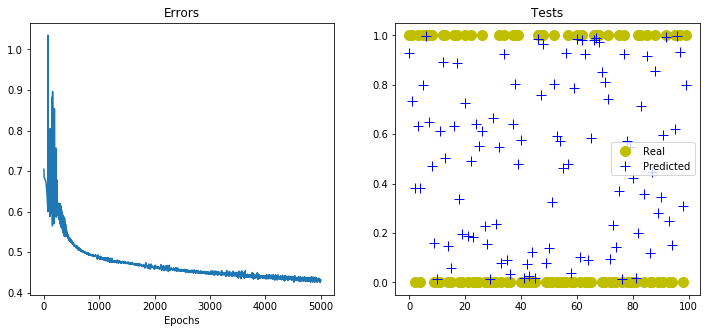

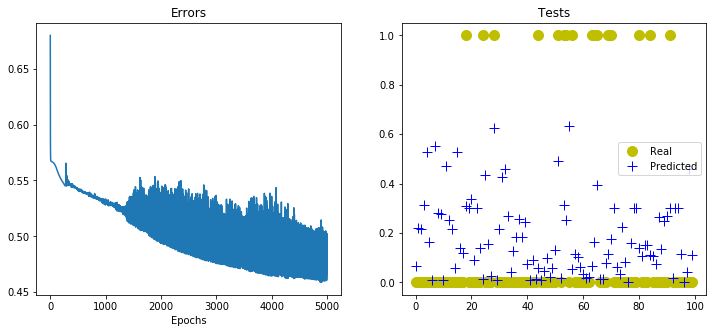

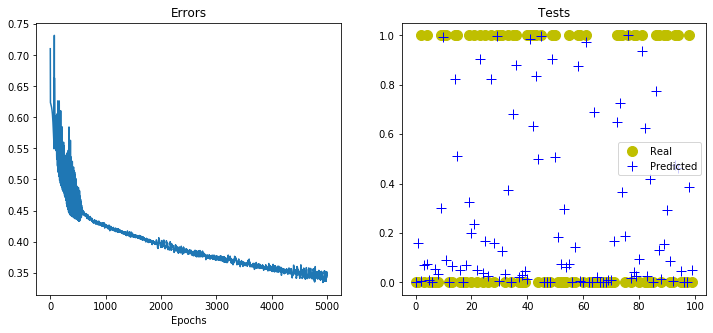

In [19]:
run_model('perfect_model.csv', 'perfect_model.csv')

In [8]:
test_input

NameError: name 'test_input' is not defined

In [37]:
df = pd.read_csv('perfect_model.csv')
training = df.iloc[50:] #select the last 1000 rows
test = df.iloc[:50] #select all but the last 1000 rows

In [38]:
len(training)

2760

In [36]:
test.head()

,home_win,away_win,draw,home_possLostAll,away_possLostAll,home_shotFastbreak,away_shotFastbreak,home_lastManTackle,away_lastManTackle,home_totalFinalThirdPasses,...,home_ballRecovery,away_ballRecovery,home_cornerTaken,away_cornerTaken,home_cornerTaken.1,away_cornerTaken.1,home_fouledFinalThird,away_fouledFinalThird,home_dispossessed,away_dispossessed
0,1,0,0,117,107,1,0,1,0,179,...,55,64,11,3,11,3,2,0,7,11
1,1,0,0,118,140,0,0,0,0,76,...,66,64,2,9,2,9,4,2,10,8
2,0,1,0,119,113,1,1,0,0,198,...,53,47,5,4,5,4,2,3,8,7
3,1,0,0,139,139,1,0,0,0,139,...,65,67,8,3,8,3,4,2,3,14
4,0,1,0,156,166,0,0,0,0,109,...,69,65,8,7,8,7,3,1,13,15


In [45]:
def test_train(perfect, dataset):
    df = pd.read_csv(perfect)
    df2 = pd.read_csv(dataset)
    
    training = df.iloc[200:] #select the last 1000 rows
    test = df2.iloc[:200] #select all but the last 1000 rows

    
    #normalize the data between 0 and 1
    for e in range(3, len(training.columns)): #iterate for each column
        num = max(training.iloc[:, e].max(), test.iloc[:, e].max()) #check the maximum value in each column
        if num < 10:
            training.iloc[:, e] /= 10
            test.iloc[:, e] /= 10
        elif num < 100:
            training.iloc[:, e] /= 100
            test.iloc[:, e] /= 100
        elif num < 1000:
            training.iloc[:, e] /= 1000
            test.iloc[:, e] /= 1000
        elif num < 10000:
            training.iloc[:, e] /= 10000
            test.iloc[:, e] /= 10000
        else:
            print("Error in normalization! Please check!")
            
    #training = training.sample(frac=1) #shuffle the training data
    #test = test.sample(frac=1) #shuffle the test data
    
    home = [1,0,0]
    draw = [0,1,0]
    away = [0,0,1]
    
    for x in range(3):
        #all rows, all columns except for the last 3 columns
        training_input  = training.iloc[:, 3:]
        #all rows, the last 3 columns
        training_output = training.iloc[:, :3]
        #all rows, all columns except for the last 3 columns
        test_input  = test.iloc[:, 3:]
        #all rows, the last 3 columns
        test_output = test.iloc[:, :3]
        
        training_output = convert_output_win(training_output, home[x], draw[x], away[x])
        test_output = convert_output_win(test_output,home[x], draw[x], away[x])
        
        training_input = torch.FloatTensor(training_input.values)
        training_output = torch.FloatTensor(training_output.values)
        test_input = torch.FloatTensor(test_input.values)
        test_output = torch.FloatTensor(test_output.values)
        
        input_size = training_input.size()[1] # number of features selected
        hidden_size = 20 # number of nodes/neurons in the hidden layer
        model = Net(input_size, hidden_size) # create the model
        criterion = torch.nn.BCELoss() # works for binary classification
        # without momentum parameter
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.9) 
        #with momentum parameter
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.9, momentum=0.2)
        
        model.eval()
        y_pred = model(test_input)
        
        model.train()
        epochs = 5000
        errors = []
        for epoch in range(epochs):
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(training_input)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), training_output)
            errors.append(loss.item())
            #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
            # Backward pass
            loss.backward()
            optimizer.step()
            
    
        model.eval()
        y_pred = model(test_input)
        
        with open(str(x)+".txt", "a") as f:
            for x in y_pred:
                f.write(str(x))
                f.write("\n")
        
        plotcharts(errors, test_output, y_pred)

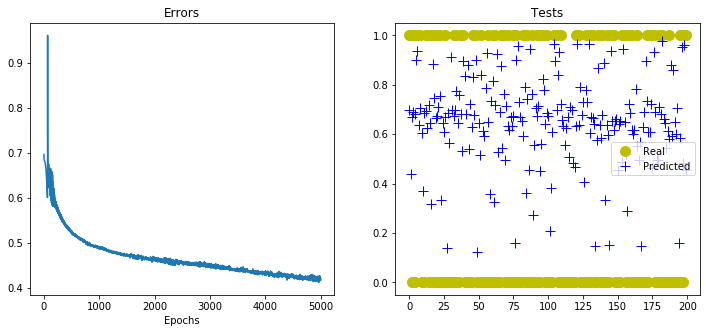

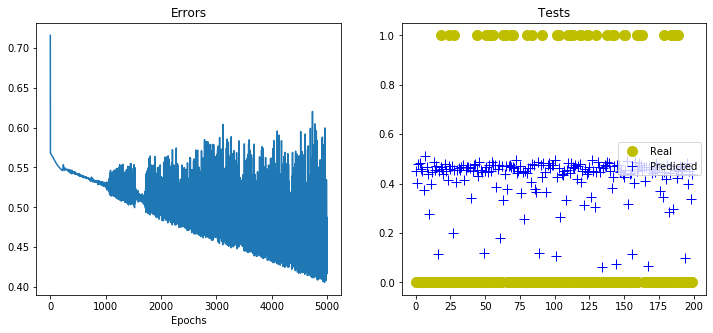

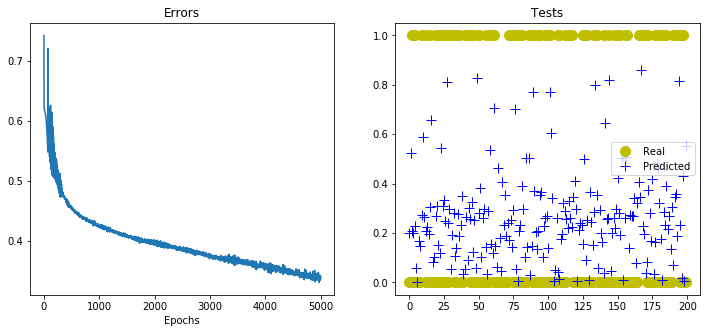

In [46]:
test_train('perfect_model.csv', 'train.csv')